In [1]:
import re
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier  
import seaborn as sb
from sklearn import tree
import pydotplus
import matplotlib as plt
from IPython.display import Image
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
plt.interactive(False)
%matplotlib inline

C:\Users\yhoresh\Anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
sentence_1 = "For sale - Apples and Oranges"
sentence_2 = "Apple and Orange fruits for sale"


In [3]:
sentence_1 = sentence_1.lower()
sentence_2 = sentence_2.lower()

In [4]:
sentence_1, sentence_2

('for sale - apples and oranges', 'apple and orange fruits for sale')

In [5]:
sentence_1 = re.sub('\W+', '', sentence_1)
sentence_2 = re.sub('\W+', '', sentence_2)
sentence_1, sentence_2

('forsaleapplesandoranges', 'appleandorangefruitsforsale')

In [6]:
def get_3_tuples(x):
    return set(x[i:i+3] for i in range(len(x)-4))

In [7]:
sentence_1_tuples = get_3_tuples(sentence_1) 
sentence_1_tuples

{'ale',
 'and',
 'ang',
 'app',
 'dor',
 'eap',
 'esa',
 'for',
 'lea',
 'les',
 'ndo',
 'ora',
 'ors',
 'ple',
 'ppl',
 'ran',
 'rsa',
 'sal',
 'san'}

In [8]:
sentence_2_tuples = get_3_tuples(sentence_2) 
sentence_2_tuples

{'and',
 'ang',
 'app',
 'dor',
 'ean',
 'efr',
 'for',
 'fru',
 'gef',
 'its',
 'lea',
 'ndo',
 'nge',
 'ora',
 'ors',
 'ple',
 'ppl',
 'ran',
 'rsa',
 'rui',
 'sfo',
 'tsf',
 'uit'}

In [9]:
sent_intersection = sentence_1_tuples.intersection(sentence_2_tuples)
sent_intersection

{'and',
 'ang',
 'app',
 'dor',
 'for',
 'lea',
 'ndo',
 'ora',
 'ors',
 'ple',
 'ppl',
 'ran',
 'rsa'}

In [10]:
sent_union = sentence_1_tuples.union(sentence_2_tuples)
sent_union

{'ale',
 'and',
 'ang',
 'app',
 'dor',
 'ean',
 'eap',
 'efr',
 'esa',
 'for',
 'fru',
 'gef',
 'its',
 'lea',
 'les',
 'ndo',
 'nge',
 'ora',
 'ors',
 'ple',
 'ppl',
 'ran',
 'rsa',
 'rui',
 'sal',
 'san',
 'sfo',
 'tsf',
 'uit'}

In [11]:
len(sent_intersection) 

13

In [12]:
len(sent_union)

29

In [13]:
len(sent_intersection)  / len(sent_union)

0.4482758620689655

# a simple classifier

In [14]:
# load the titanik dataset
df = pd.read_csv(r'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv')

In [15]:
df.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
813,814,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S
74,75,1,3,"Bing, Mr. Lee",male,32.0,0,0,1601,56.4958,NaN,S
68,69,1,3,"Andersson, Miss. Erna Alexandra",female,17.0,4,2,3101281,7.9250,NaN,S
322,323,1,2,"Slayter, Miss. Hilda Mary",female,30.0,0,0,234818,12.3500,NaN,Q
485,486,0,3,"Lefebre, Miss. Jeannie",female,NaN,3,1,4133,25.4667,NaN,S
770,771,0,3,"Lievens, Mr. Rene Aime",male,24.0,0,0,345781,9.5000,NaN,S
531,532,0,3,"Toufik, Mr. Nakli",male,NaN,0,0,2641,7.2292,NaN,C
419,420,0,3,"Van Impe, Miss. Catharina",female,10.0,0,2,345773,24.1500,NaN,S
650,651,0,3,"Mitkoff, Mr. Mito",male,NaN,0,0,349221,7.8958,NaN,S
532,533,0,3,"Elias, Mr. Joseph Jr",male,17.0,1,1,2690,7.2292,NaN,C


<AxesSubplot:>

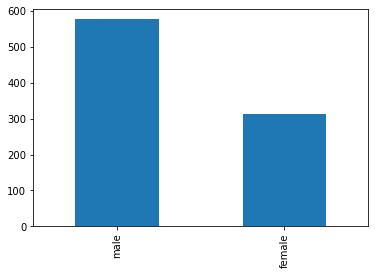

In [16]:
df.Sex.value_counts().plot(kind='bar')

In [17]:
def normalized_name(name):
    name = name.lower()
    name = re.sub('mr\.|miss\.|mrs\.', '', name)
    name = re.sub('\W+', '', name)
    return name

In [18]:
%%time
df['norm_name'] = df['Name'].apply(normalized_name)
df['tuples'] = df['norm_name'].apply(get_3_tuples)

CPU times: total: 15.6 ms
Wall time: 7.98 ms


In [19]:
df[['Name', 'norm_name','tuples']]

,Name,norm_name,tuples
0,"Braund, Mr. Owen Harris",braundowenharris,"{aun, rau, dow, enh, owe, und, ndo, nha, bra, ..."
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",cumingsjohnbradleyflorencebriggsthayer,"{dle, ore, sth, bra, ngs, nce, rig, gsj, tha, ..."
2,"Heikkinen, Miss. Laina",heikkinenlaina,"{eik, nen, hei, kki, lai, ikk, kin, nla, enl, ..."
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",futrellejacquesheathlilymaypeel,"{rel, may, lej, lym, hea, lil, yma, ues, ily, ..."
4,"Allen, Mr. William Henry",allenwilliamhenry,"{all, nwi, enw, lia, amh, hen, mhe, ill, iam, ..."
...,...,...,...
886,"Montvila, Rev. Juozas",montvilarevjuozas,"{are, uoz, vil, tvi, ila, evj, rev, ntv, lar, ..."
887,"Graham, Miss. Margaret Edith",grahammargaretedith,"{gar, rga, are, gra, edi, arg, mma, amm, ete, ..."
888,"Johnston, Miss. Catherine Helen ""Carrie""",johnstoncatherinehelencarrie,"{sto, nca, arr, eri, cat, hel, onc, hns, ehe, ..."
889,"Behr, Mr. Karl Howell",behrkarlhowell,"{how, hrk, rka, ehr, owe, kar, rlh, beh, arl, ..."


In [20]:
%%time
list_of_tokens = []
for ind, row in df.iterrows():

    tuples = dict()
    for item in row.tuples:
        tuples[item] = 1
        
    tuples['index'] = ind
    tuples['gender'] = 1 if row.Sex=='female' else 0
    
    list_of_tokens.append(tuples)
    

CPU times: total: 62.5 ms
Wall time: 39.9 ms


In [21]:
list_of_tokens[0:1]

[{'aun': 1,
  'rau': 1,
  'dow': 1,
  'enh': 1,
  'owe': 1,
  'und': 1,
  'ndo': 1,
  'nha': 1,
  'bra': 1,
  'wen': 1,
  'arr': 1,
  'har': 1,
  'index': 0,
  'gender': 0}]

In [22]:
three_tuples_df = pd.DataFrame(list_of_tokens)
three_tuples_df.fillna(0, inplace=True)
three_tuples_df.sample(5)

,aun,rau,dow,enh,owe,und,ndo,nha,bra,wen,...,cew,uoz,ntv,juo,vju,neh,hrk,rlh,beh,ypa
794,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
127,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
883,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
697,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
%%time
all_columns_but_gender = three_tuples_df.columns[three_tuples_df.columns != 'gender']
X_train, X_test, y_train, y_test = train_test_split(three_tuples_df[all_columns_but_gender], three_tuples_df['gender'], test_size=0.2, random_state=42)

CPU times: total: 15.6 ms
Wall time: 20.9 ms


In [24]:
%%time
classifier = XGBClassifier( use_label_encoder=False) #class_weight='balanced',
model = classifier.fit(X_train, y_train)

prediction = model.predict(X_test)

print(classification_report(y_test, prediction))

confusion_matrix(y_test, prediction)


[13:25:49] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\yhoresh\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


              precision    recall  f1-score   support

           0       0.81      0.90      0.85       110
           1       0.81      0.67      0.73        69

    accuracy                           0.81       179
   macro avg       0.81      0.78      0.79       179
weighted avg       0.81      0.81      0.81       179

CPU times: total: 20.1 s
Wall time: 1.83 s


array([[99, 11],
       [23, 46]], dtype=int64)

<AxesSubplot:xlabel='imp', ylabel='name'>

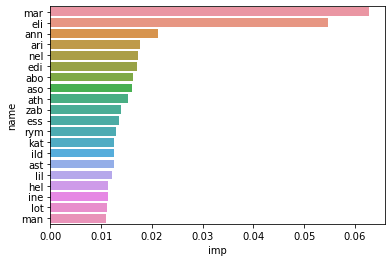

In [25]:
#feature_importances
feature_imp = pd.DataFrame(data=list(zip(model.feature_importances_, all_columns_but_gender)), columns=['imp', 'name'])
feature_imp.sort_values(by='imp', ascending=False, inplace=True)

sb.barplot(x=feature_imp.imp[0:20], y=feature_imp.name[0:20])


DecisionTreeClassifier(max_depth=4, min_samples_leaf=3, min_samples_split=3)

True

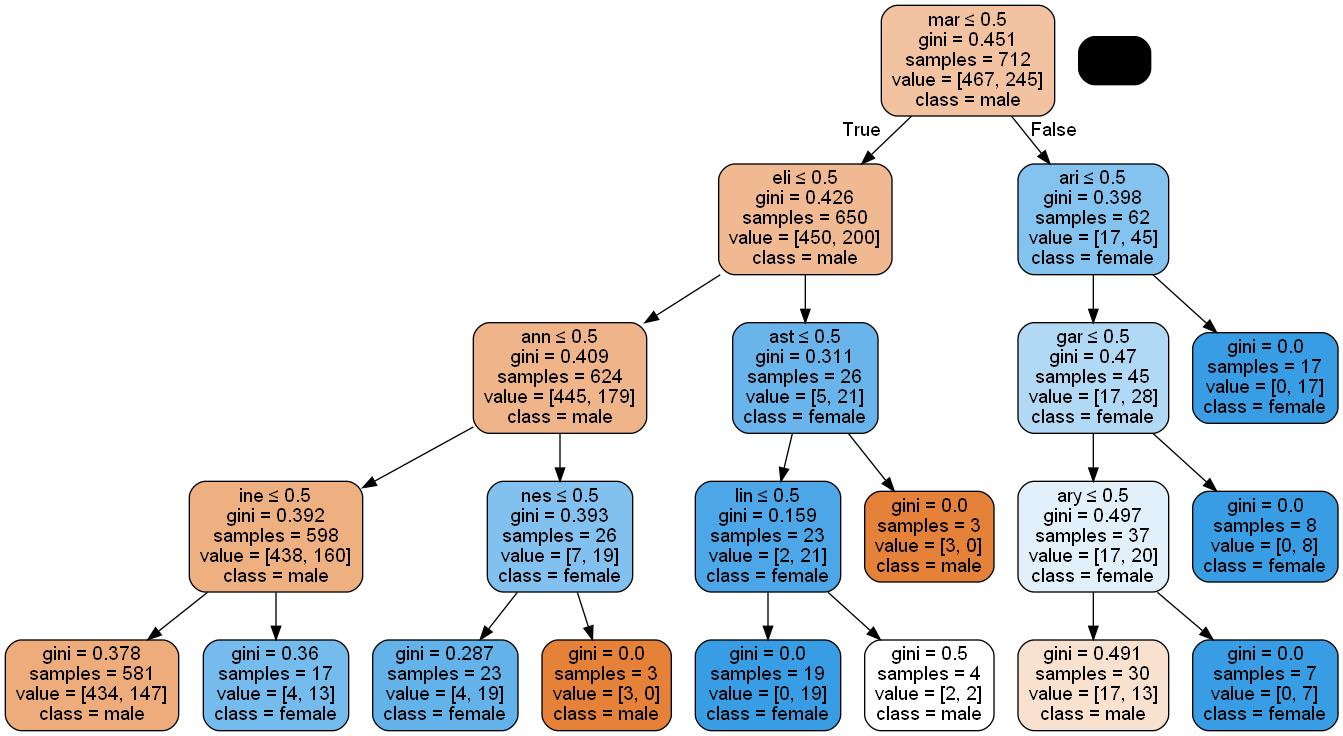

In [28]:
tree_classifier = tree.DecisionTreeClassifier(max_depth=4, min_samples_leaf=3, min_samples_split=3)
tree_classifier.fit(X_train, y_train)

dot_data = tree.export_graphviz(tree_classifier, out_file=None, class_names=['male','female'], feature_names=all_columns_but_gender, filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_jpeg('dummy.jpeg')
Image(filename='dummy.jpeg', width=1000, height=1000)

prediction = tree_classifier.predict(X_test)


In [27]:
print(classification_report(y_test, prediction))

confusion_matrix(y_test, prediction)

              precision    recall  f1-score   support

           0       0.72      0.92      0.81       110
           1       0.77      0.43      0.56        69

    accuracy                           0.73       179
   macro avg       0.75      0.68      0.68       179
weighted avg       0.74      0.73      0.71       179



array([[101,   9],
       [ 39,  30]], dtype=int64)